## Imports

In [7]:
import numpy as np
from random import random, seed
from IPython import embed
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.neural_network import MLPClassifier
import imageio.v2 as imageio
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from utils import *
from functions import *
from ffnn import *

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

## Make data

In [8]:
# Make data
np.random.seed(42)
n = 200           # datapoints
x= np.sort(np.random.uniform(-5,5,(n,1)), axis=0)
y = (1+x+ x**2 + 2*np.random.randn(n,1))
y_dim = np.reshape(y, (n,1))            # add dimension

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#sort for plotting
x_test, y_test = zip(*sorted(zip(x_test, y_test)))
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

## Run FFNN code from course

In [9]:
# Learning parameters
epochs = 500
batch_size = 10 # own implementation takes size as input
batches = int(len(y_train)/batch_size) # R&K ffnn take number of batches as input

# Network architecture
input_nodes = x_train.shape[1]
output_nodes = 1
dims=(input_nodes,50,50,50,output_nodes)
#course code
input_nodes = x_train.shape[1]
output_nodes = 1
dims=(input_nodes,50,50,50,output_nodes)

eta = 1e-3
lmbd = 0.01

# course fnn
linear_regression = FFNN(dims, output_func=identity,cost_func=CostOLS, seed=203)
linear_regression.reset_weights() # reset weights such that previous runs or reruns don't affect the weights
scheduler = Constant(eta=eta)
scores = linear_regression.fit(x_train, y_train,scheduler,epochs=epochs,lam=lmbd,batches=batches, X_val=x_test, t_val=y_test)
y_pred_course = linear_regression.predict(x_test)
y_pred_course_train = linear_regression.predict(x_train)
course_mse = scores['val_errors'][-1] 
course_mse_train = scores['train_errors'][-1]
print(f'\nmse K&R: {course_mse}')


Constant: Eta=0.001, Lambda=0.01
  [=======================================>] 100.0% | train_error: 3.96 | val_error: 4.61  
mse K&R: 4.607800954130461


## Run self-written FFNN code

In [10]:
# own ffnn
dnn = Feed_forward_nn(x_train, y_train, layer_dim=(50,50,50), 
                      n_outputs =output_nodes,
                      epochs=epochs, batch_size=batch_size, 
                      eta=eta, lmbd=lmbd)
dnn.train()
y_pred_own = dnn.feed_forward_out(x_test)
y_pred_own_train = dnn.feed_forward_out(x_train)
own_mse = mean_squared_error(y_pred_own, y_test)
own_mse_train = mean_squared_error(y_pred_own_train, y_train)
print(f'mse own code: {own_mse}')

mse own code: 4.590933458147214


In [11]:
# linear regression

# make design matrix using same data as for ffnn
size_test = round(n*0.2)
size_train = n-size_test
X_test_reg = np.c_[np.ones((size_test,1)), x_test, x_test**2] 
X_train_reg = np.c_[np.ones((size_train,1)), x_train, x_train**2]

# predict using OLS
beta = ols(X_train_reg, y_train)
y_pred_ols = X_test_reg @ beta
y_pred_ols_train = X_train_reg @ beta
ols_mse = mean_squared_error(y_pred_ols, y_test)
ols_mse_train = mean_squared_error(y_pred_ols_train, y_train)
print(f'MSE OLS: {ols_mse}')

# predict using Ridge

beta_ridge = ridge(X_train_reg, y_train, lambd=50)
y_pred_ridge = X_test_reg @ beta_ridge
y_pred_ridge_train = X_train_reg @ beta_ridge
ridge_mse_test = mean_squared_error(y_pred_ridge, y_test)
ridge_mse_train = mean_squared_error(y_pred_ridge_train, y_train)
print(f'MSE Ridge: {ridge_mse_test}')


MSE OLS: 4.349603454750787
MSE Ridge: 4.388981621901176


In [12]:
# Pytorch
# seed to get same randomness every time
torch.manual_seed(42)
# Create regression model
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = self.fc4(x)
        return x

x_train_torch = torch.from_numpy(x_train).float()
x_test_torch = torch.from_numpy(x_test).float()
y_train_torch = torch.from_numpy(y_train).float()
y_test_torch = torch.from_numpy(y_test).float()

eta = 1e-3
lmbd = 0.01

model = RegressionModel(input_nodes, 50, 50, 50, output_nodes)  # You can adjust the hidden layer sizes as needed
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.SGD(model.parameters(), lr=eta, weight_decay=lmbd)  # Stochastic Gradient Descent optimizer 

for epoch in range(epochs):
    for i in range(0, n, batch_size):
        inputs = x_train_torch[i:i+batch_size]
        targets = y_train_torch[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

       # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
with torch.no_grad():
    y_pred_torch = model(x_test_torch)
    y_pred_torch_train = model(x_train_torch)

mse_torch = mean_squared_error(y_test, y_pred_torch)
mse_torch_train = mean_squared_error(y_train, y_pred_torch_train)

print(f'MSE PyTorch: {mse_torch}')

MSE PyTorch: 4.74259805581183


## Plot all models

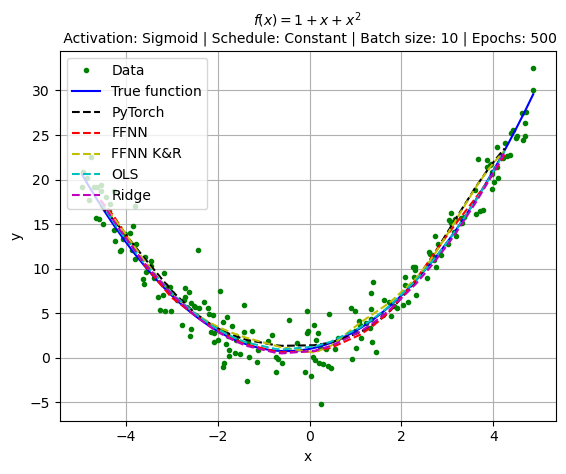

In [13]:

fig1 = plt.figure()
plt.plot(x, y, 'g.', label='Data')
plt.plot(x,1+x+ x**2, 'b-', label='True function')
plt.plot(x_test, y_pred_torch, 'k--', label='PyTorch')
plt.plot(x_test,y_pred_own, 'r--', label='FFNN')
plt.plot(x_test,y_pred_course, 'y--', label='FFNN K&R')
plt.plot(x_test,y_pred_ols, 'c--', label='OLS')
plt.plot(x_test,y_pred_ridge, 'm--', label='Ridge')

plt.grid(), plt.xlabel('x'), plt.ylabel('y'), plt.legend(loc='upper left') 
plt.title(f'$f(x) = 1 + x + x^2$ \n Activation: Sigmoid | Schedule: Constant | Batch size: {batch_size} | Epochs: {epochs}', fontsize=10)
#plt.show()
plt.savefig('simple_pol_compare.png')

In [14]:
scores = {'Dataset': ['Train','Test'], 
          '# samples': [len(y_train), len(y_test)],
          'OLS':[ols_mse_train,ols_mse], 
          'Ridge':[ridge_mse_train, ridge_mse_test],
          'Own FFNN': [own_mse_train, own_mse],
          'K&R FFNN': [course_mse_train, course_mse],
          'PyTorch': [mse_torch_train, mse_torch]
          
         }
pd.set_option('display.float_format', lambda x: '%.1f' % x)
score_table = pd.DataFrame(data=scores)
table = pretty_print(score_table)

,Dataset,# samples,OLS,Ridge,Own FFNN,K&R FFNN,PyTorch
0,Train,160,3.6,3.7,3.5,4.0,3.9
1,Test,40,4.3,4.4,4.6,4.6,4.7


## Find best parameters for all learning schedules

In [40]:

# check batch sizes 

# Learning parameters
epochs = 10
batches = 5
eta_vals=np.logspace(-6, 3, 20)
lmbd_vals=np.logspace(-6, 3, 20)

#define solution vectors
train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

#int(len(y_train)/batch_size) # R&K ffnn take number of batches as input
X_test_reg = np.c_[np.ones((size_test,1)), x_test, x_test**2] 
X_train_reg = np.c_[np.ones((size_train,1)), x_train, x_train**2]


# Network architecture
input_nodes = X_train_reg.shape[1]
output_nodes = 1
dims=(input_nodes,output_nodes)

Scheduler =['Constant','Adagrad','RMS_prop','Adam','Momentum','AdagradMomentum']
result_dict = {'Scheduler':[], 
               'Eta':[], 
               'Lambda':[],  
               'Test error':[],
               'Train error':[],
               'Epochs':[], 
               'Batches':[]
              }
for scheduler_name in Scheduler:
    for i, eta in enumerate(eta_vals):
        for j, lmbd in enumerate(lmbd_vals):
    
            match scheduler_name:
                case 'Constant': 
                    eta = eta
                    scheduler = Constant(eta=eta)
                    lmbd=lmbd
                case 'Adagrad':
                    eta=eta
                    scheduler = Adagrad(eta=eta)
                    lmbd=lmbd
                case 'RMS_prop': 
                    eta=eta
                    scheduler = RMS_prop(eta=eta, rho=0.9)
                    lmbd=lmbd
                case 'Adam':
                    eta=eta
                    scheduler = Adam(eta=eta, rho=0.9, rho2=0.999)
                    lmbd=lmbd
                case 'Momentum':
                    eta=eta
                    momentum = 0.3
                    scheduler = Momentum(eta=eta, momentum = 0.3)
                    lmbd=lmbd
                case 'AdagradMomentum':
                    eta=eta
                    scheduler = AdagradMomentum(eta=eta, momentum = 0.3)
                    lmbd=lmbd
        
            # ffnn without hidden layer, approximates linear regression
            linear_regression = FFNN(dims, output_func=identity,cost_func=CostOLS, seed=203)
            linear_regression.reset_weights() # reset weights such that previous runs or reruns don't affect the weights
            try:
                scores = linear_regression.fit(X_train_reg, 
                                           y_train,scheduler,
                                           epochs=epochs,
                                           lam=lmbd,
                                           batches=batches, 
                                           X_val=X_test_reg, 
                                           t_val=y_test)
                train_accuracy[i][j] = scores['train_errors'][-1]
                test_accuracy[i][j] = scores['val_errors'][-1]
            except: 
                train_accuracy[i][j] = np.nan
                test_accuracy[i][j] = np.nan
                
            result_dict['Scheduler'].append(scheduler_name)
            result_dict['Eta'].append(eta)
            result_dict['Lambda'].append(lmbd)
            result_dict['Epochs'].append(epochs)
            result_dict['Batches'].append(batches)
            result_dict['Train error'].append(train_accuracy[i][j])
            result_dict['Test error'].append(test_accuracy[i][j])
            
# Make into pd dataframe and print the best eta,lambda
result_pd = pd.DataFrame.from_dict(result_dict)
res=result_pd.sort_values(['Test error']).groupby(['Scheduler']).head(1)
print(res)


Constant: Eta=1e-06, Lambda=1e-06
  [=======================================>] 100.0% | train_error: 524 | val_error: 332 Constant: Eta=1e-06, Lambda=2.976351441631319e-06
  [=======================================>] 100.0% | train_error: 524 | val_error: 332 Constant: Eta=1e-06, Lambda=8.858667904100832e-06
  [=======================================>] 100.0% | train_error: 524 | val_error: 332 Constant: Eta=1e-06, Lambda=2.6366508987303556e-05
  [=======================================>] 100.0% | train_error: 524 | val_error: 332 Constant: Eta=1e-06, Lambda=7.847599703514606e-05
  [=======================================>] 100.0% | train_error: 524 | val_error: 332 Constant: Eta=1e-06, Lambda=0.00023357214690901214
  [=======================================>] 100.0% | train_error: 524 | val_error: 332 Constant: Eta=1e-06, Lambda=0.0006951927961775605
  [=======================================>] 100.0% | train_error: 524 | val_error: 332 Constant: Eta=1e-06, Lambda=0.002069138081114788

  [=======================================>] 100.0% | train_error: 417 | val_error: 265 Constant: Eta=8.858667904100832e-06, Lambda=112.88378916846884
  [=======================================>] 100.0% | train_error: 404 | val_error: 258 Constant: Eta=8.858667904100832e-06, Lambda=335.9818286283774
  [=======================================>] 100.0% | train_error: 368 | val_error: 239 Constant: Eta=8.858667904100832e-06, Lambda=1000.0
  [=======================================>] 100.0% | train_error: 291 | val_error: 196 Constant: Eta=2.6366508987303556e-05, Lambda=1e-06
  [=======================================>] 100.0% | train_error: 264 | val_error: 168 Constant: Eta=2.6366508987303556e-05, Lambda=2.976351441631319e-06
  [=======================================>] 100.0% | train_error: 264 | val_error: 168 Constant: Eta=2.6366508987303556e-05, Lambda=8.858667904100832e-06
  [=======================================>] 100.0% | train_error: 264 | val_error: 168 Constant: Eta=2.6366508

  [=======================================>] 100.0% | train_error: 9.90 | val_error: 8.63 Constant: Eta=0.00023357214690901214, Lambda=0.1623776739188721
  [=======================================>] 100.0% | train_error: 9.88 | val_error: 8.61 Constant: Eta=0.00023357214690901214, Lambda=0.4832930238571752
  [=======================================>] 100.0% | train_error: 9.81 | val_error: 8.55 Constant: Eta=0.00023357214690901214, Lambda=1.438449888287663
  [=======================================>] 100.0% | train_error: 9.61 | val_error: 8.39 Constant: Eta=0.00023357214690901214, Lambda=4.281332398719387
  [=======================================>] 100.0% | train_error: 9.08 | val_error: 7.96  Constant: Eta=0.00023357214690901214, Lambda=12.742749857031322
  [=======================================>] 100.0% | train_error: 7.98 | val_error: 7.15 Constant: Eta=0.00023357214690901214, Lambda=37.92690190732246
  [=======================================>] 100.0% | train_error: 7.90 | val_

  [=======================================>] 100.0% | train_error: 195810388704524372165914238226690681765266162691329513540458241720479591175280004639614587645580002264707221519849885789564738162797838336 | val_error: 124505716194717598164548185371323360561945394291850110010597813134211609702053628310858205537095558922446233397606434185194386515264798720 Constant: Eta=0.05455594781168514, Lambda=1e-06
  [=======================================>] 100.0% | train_error: 705749752839037452748739087573013255059439191388813715291650600699072566610796525405220502742578791648804238939652096 | val_error: 449833393457953349252293418166307172723906400956309549909922454299210940090556275314846794508781482370753191045234688 Constant: Eta=0.05455594781168514, Lambda=2.976351441631319e-06
  [=======================================>] 100.0% | train_error: 705750306903315003122447372923032135035576173957494196479540616480151256412129423910657624669904572505943292107554816 | val_error: 4498337466147410

  [=======================================>] 100.0% | train_error: 19315447214706079995554060565707622905817439919498303856334393333212218512278250443280694411215377997643871315974087630605244379750866869243815468262839674716370763776 | val_error: 12311877199385910254503650950804931684817592124911806442346723091170123258605560116430140674580356026787904133954628313798887219567726936279538886068968424466435538944 Constant: Eta=0.1623776739188721, Lambda=2.976351441631319e-06
  [=======================================>] 100.0% | train_error: 19315461643739576950000213602222955187850974880382281624650986160490462140297517591791145885101683300430101466059442479811027841532082132744042530773227368168384626688 | val_error: 12311886396637034927116111554695280158505417164377785442924697903400501702370454388827059632439364602971891421778608280943936374465493735025918567263089044212072579072 Constant: Eta=0.1623776739188721, Lambda=8.858667904100832e-06
  [=======================================

  [=======================================>] 100.0% | train_error: 22561202113138478782250487440098538380241247270571367826345539853648979552876534428314336025596022925726062479300017588422480804489773443672654515973939503584313615042920230316040076227003256355449037067823590932480 | val_error: 14380786670569562064958691265966770846529141491017194884764430757292937658258758839367671126083397915643120054498549232602268640687248339133418665239872089096335282392048552534344834388381346313260582139381613068288 Constant: Eta=0.4832930238571752, Lambda=0.4832930238571752
  [=======================================>] 100.0% | train_error: 25417628499379557390007523109662730547789771791774287872809521405306117833420279077725826849770415866015870697767681923032400006218770087289433145960947586563176359241350088091278149029440427545135010397799013416960 | val_error: 162015060793739333686004465487251302542082742586852263263879831052726603343474921528380764496626178712688311953133598382331371456074

  [=======================================>] 100.0% | train_error: 4078140914508362930232252879506957621853690062930763095948741838922099013590458937933217090328290465974543414205546825827652065271037276283698669208567791100295615702815051036617288845867663334803398145674857608711193577114595654851080227886749790018345138553173835776 | val_error: 2598962303169749059522601996145869136182255758928952696289252487703605915202324318827622376677714870493257586765968336851242427156904169961003860833017714198320561979347367991115054323165730686467368613269662052204113343162509664508000629323436635604968538299502166016 Constant: Eta=1.438449888287663, Lambda=112.88378916846884
  [=======================================>] 100.0% | train_error: 1028796885332917564256479189773432243521573237717735636442033867616684214857017513745873873474444615608142287163856242297142424108077950564897115582041946207264415667483165896652522639680992955065929031150570149969532946144670618576991162402060156762951128

  [===========================>------------] 70.00% | train_error: 670709286914744414630296807862756819343054946058999983956591083365108830524058575407297003681953660402523199793359902919182721118159314274415281153730998943607950972592033964924008369297725530948465180266210681665182875341125657868927680216796913284068016619060520993838596096 | val_error: 426633554431451923507888056404898258746716842522018775081326721667681970353855393122240109811382415393631893901641953205106383394294672957240422934514850449514188461292833544074144423458270787712760679118415713772708420757585431070380790971673935886136806333906580056685150208 Constant: Eta=4.281332398719387, Lambda=1000.0
  [===========================>------------] 70.00% | train_error: 189594514577492714346766212391745175767782234555943913519869423859489197089757595135279763801413684631216983176050321860223370917542808427341444422147230421235988483163809945829801086120747458184883545089585286714270107087021236589066525190546084233903

  [=======================>----------------] 60.00% | train_error: 48716941456990612928493359318004316258408922046723473733783216542694991110407948335577350274126895997456974260110187014870683307481544001421428476006889078829796852519737565345445722563997383549960073391920597872895390835629203610431325044115369403021221170298916514262003169544372224 | val_error: 31052746516877040964267076385683431167078190583495260180543645033570251124798126565551106716958897857147371274824011532792907955600123917259406224525624288371854926516288026603303212991051901138999115997822760070701803903094079197706094172726415168548594914037377642930787532442435584 Constant: Eta=37.92690190732246, Lambda=2.976351441631319e-06
  [=======================>----------------] 60.00% | train_error: 48716966248731389835662353315304405027155501220588971735791564016413405146950566627547078531864526970959305947279150307857047323244847745013636537779100443844274376108548140488624434808877291092625898675992277808782330289

  [===================>--------------------] 50.00% | train_error: 91626419545809482254843919172002334673040092024843965707322339408818965678744127315405615707783848515791932947123790139159054640150008295727163816592391809187948745037205469780540600564565876805338705268606379322075566634689956008401039191012997944856640298832309228929024 | val_error: 58403747354887942855897780006868511829638206439594595400492699333625468512698907566188219398991804995896319056408563969233530665561242723162253899780238866140311131845130855271305437068581379894858768716177358247638643950858444589989239891644615032335428181929769572499456 Constant: Eta=112.88378916846884, Lambda=2.6366508987303556e-05
  [===================>--------------------] 50.00% | train_error: 916267729648962737003112211343401147105950029588405171074091154519723135527161483929541571814215046250774519462716022493982519724878434232310207459630381260229412950739507278511333292250691749329238489169421425346442326302797411992718193487798

  [===================>--------------------] 50.00% | train_error: 233537994085097793379140628492973370761693071531176542359951513704632792970089552518458357774244124586290454113084769196289475667178607038608258082964517937588474809755669708598508696256029828171383522012177362866127432577874527701931002203418279470338522539544356551917568 | val_error: 148858875651235264827371064146482679548585887106598281864756661553029596066829152885675061782713586129503114753478040977849544429645138852305969647392488722201555089585640298111766716788374358531778768213350024457048898614644492143921589346592745237038862949655812660789248 Constant: Eta=112.88378916846884, Lambda=12.742749857031322
  [===================>--------------------] 50.00% | train_error: 14211478548576356340784688725220776206135742744384321624337040262236894124129076052013760809344355997928582208776551382225493974579390683263279595704314199965897123490266763597621527385337374829747890779494395582481149801921003104331009940128640

  [===================>--------------------] 50.00% | train_error: 5942290843712450257938191669099899852965683442052393678431461972320743910833387592933007654432261181477628229735332176116431509032148482724026893896793993581451331009414906184105182030418441035097811465284896259207482195199496233411484693946601581780329950066744065604520860846512511536796479464849539072 | val_error: 3786947254471424187817251045552347259289511980922804209767401060660243454315180137079859439335665790147332180636197491073705319449713652499016921101755196550923241327350651211502179582732387228135568202919338852800345244785329871816196788934833644272620989193877612556509174717909004343543245602478358528 Constant: Eta=335.9818286283774, Lambda=112.88378916846884
  [===============>------------------------] 40.00% | train_error: 1738171546179747945132274543310906174820595570276619845894282798030755221975361687521596429724183186563950520852209570304546592740135817690645801190440998019111813406744655620284773845

  [===============>------------------------] 40.00% | train_error: 27927174098594156059070360587635069474377871249316242571813123448508882945216948468647995775134602018952980323721879104340205406234155161320495477581205483635385812958784308103171074976672657016840248189725855661939864877426076159758338382236696441322881977359234246616547328 | val_error: 17801105940412924196371771073565099645763837374606425492224087362130810462921191655660109478700536877083167425405086103838501816310423269392153669876368189446172414692321792245420643522947939975674552137193601663331750185779721179962258931344856394697233757920735486629904384 Constant: Eta=1000.0, Lambda=0.01832980710832434
  [===============>------------------------] 40.00% | train_error: 279894926307466796749356083630797065754906085601477623481822420213220348645516149873818144550749969046961518214269315234268003093879622603344155417531598026899753931911542411292782280982203813394572609427711579850115897481297544782619344116548267622097

  [=======================================>] 100.0% | train_error: 539 | val_error: 341 Adagrad: Eta=8.858667904100832e-06, Lambda=112.88378916846884
  [=======================================>] 100.0% | train_error: 539 | val_error: 341 Adagrad: Eta=8.858667904100832e-06, Lambda=335.9818286283774
  [=======================================>] 100.0% | train_error: 539 | val_error: 341 Adagrad: Eta=8.858667904100832e-06, Lambda=1000.0
  [=======================================>] 100.0% | train_error: 539 | val_error: 341 Adagrad: Eta=2.6366508987303556e-05, Lambda=1e-06
  [=======================================>] 100.0% | train_error: 538 | val_error: 341 Adagrad: Eta=2.6366508987303556e-05, Lambda=2.976351441631319e-06
  [=======================================>] 100.0% | train_error: 538 | val_error: 341 Adagrad: Eta=2.6366508987303556e-05, Lambda=8.858667904100832e-06
  [=======================================>] 100.0% | train_error: 538 | val_error: 341 Adagrad: Eta=2.63665089873035

  [=======================================>] 100.0% | train_error: 426 | val_error: 270 Adagrad: Eta=0.00615848211066026, Lambda=0.0006951927961775605
  [=======================================>] 100.0% | train_error: 426 | val_error: 270 Adagrad: Eta=0.00615848211066026, Lambda=0.002069138081114788
  [=======================================>] 100.0% | train_error: 426 | val_error: 270 Adagrad: Eta=0.00615848211066026, Lambda=0.00615848211066026
  [=======================================>] 100.0% | train_error: 426 | val_error: 270 Adagrad: Eta=0.00615848211066026, Lambda=0.01832980710832434
  [=======================================>] 100.0% | train_error: 426 | val_error: 270 Adagrad: Eta=0.00615848211066026, Lambda=0.05455594781168514
  [=======================================>] 100.0% | train_error: 426 | val_error: 270 Adagrad: Eta=0.00615848211066026, Lambda=0.1623776739188721
  [=======================================>] 100.0% | train_error: 426 | val_error: 270 Adagrad: Eta=0.0

  [=======================================>] 100.0% | train_error: 11.3 | val_error: 12.4 Adagrad: Eta=1.438449888287663, Lambda=37.92690190732246
  [=======================================>] 100.0% | train_error: 7.17 | val_error: 8.50 Adagrad: Eta=1.438449888287663, Lambda=112.88378916846884
  [=======================================>] 100.0% | train_error: 19.9 | val_error: 22.6 Adagrad: Eta=1.438449888287663, Lambda=335.9818286283774
  [=======================================>] 100.0% | train_error: 44.6 | val_error: 43.9 Adagrad: Eta=1.438449888287663, Lambda=1000.0
  [=======================================>] 100.0% | train_error: 85.0 | val_error: 74.9 Adagrad: Eta=4.281332398719387, Lambda=1e-06
  [=======================================>] 100.0% | train_error: 50.4 | val_error: 49.9 Adagrad: Eta=4.281332398719387, Lambda=2.976351441631319e-06
  [=======================================>] 100.0% | train_error: 50.4 | val_error: 49.9 Adagrad: Eta=4.281332398719387, Lambda=8.85866

  [=======================================>] 100.0% | train_error: 2543602 | val_error: 2365831 Adagrad: Eta=1000.0, Lambda=0.0006951927961775605
  [=======================================>] 100.0% | train_error: 2543499 | val_error: 2365739 Adagrad: Eta=1000.0, Lambda=0.002069138081114788
  [=======================================>] 100.0% | train_error: 2543195 | val_error: 2365464 Adagrad: Eta=1000.0, Lambda=0.00615848211066026
  [=======================================>] 100.0% | train_error: 2542290 | val_error: 2364644 Adagrad: Eta=1000.0, Lambda=0.01832980710832434
  [=======================================>] 100.0% | train_error: 2539598 | val_error: 2362207 Adagrad: Eta=1000.0, Lambda=0.05455594781168514
  [=======================================>] 100.0% | train_error: 2531601 | val_error: 2354963 Adagrad: Eta=1000.0, Lambda=0.1623776739188721
  [=======================================>] 100.0% | train_error: 2507923 | val_error: 2333494 Adagrad: Eta=1000.0, Lambda=0.48329302

  [=======================================>] 100.0% | train_error: 533 | val_error: 338 RMS_prop: Eta=7.847599703514606e-05, Lambda=112.88378916846884
  [=======================================>] 100.0% | train_error: 534 | val_error: 339 RMS_prop: Eta=7.847599703514606e-05, Lambda=335.9818286283774
  [=======================================>] 100.0% | train_error: 534 | val_error: 339 RMS_prop: Eta=7.847599703514606e-05, Lambda=1000.0
  [=======================================>] 100.0% | train_error: 534 | val_error: 339 RMS_prop: Eta=0.00023357214690901214, Lambda=1e-06
  [=======================================>] 100.0% | train_error: 524 | val_error: 332 RMS_prop: Eta=0.00023357214690901214, Lambda=2.976351441631319e-06
  [=======================================>] 100.0% | train_error: 524 | val_error: 332 RMS_prop: Eta=0.00023357214690901214, Lambda=8.858667904100832e-06
  [=======================================>] 100.0% | train_error: 524 | val_error: 332 RMS_prop: Eta=0.0002335

  [=======================================>] 100.0% | train_error: 4.13 | val_error: 4.36 RMS_prop: Eta=0.05455594781168514, Lambda=0.0006951927961775605
  [=======================================>] 100.0% | train_error: 4.13 | val_error: 4.36 RMS_prop: Eta=0.05455594781168514, Lambda=0.002069138081114788
  [=======================================>] 100.0% | train_error: 4.13 | val_error: 4.36 RMS_prop: Eta=0.05455594781168514, Lambda=0.00615848211066026
  [=======================================>] 100.0% | train_error: 4.13 | val_error: 4.35 RMS_prop: Eta=0.05455594781168514, Lambda=0.01832980710832434
  [=======================================>] 100.0% | train_error: 4.13 | val_error: 4.34 RMS_prop: Eta=0.05455594781168514, Lambda=0.05455594781168514
  [=======================================>] 100.0% | train_error: 4.11 | val_error: 4.32 RMS_prop: Eta=0.05455594781168514, Lambda=0.1623776739188721
  [=======================================>] 100.0% | train_error: 4.21 | val_error: 4

  [=======================================>] 100.0% | train_error: 49.7 | val_error: 48.5 RMS_prop: Eta=1.438449888287663, Lambda=2.976351441631319e-06
  [=======================================>] 100.0% | train_error: 49.7 | val_error: 48.5 RMS_prop: Eta=1.438449888287663, Lambda=8.858667904100832e-06
  [=======================================>] 100.0% | train_error: 49.7 | val_error: 48.5 RMS_prop: Eta=1.438449888287663, Lambda=2.6366508987303556e-05
  [=======================================>] 100.0% | train_error: 49.7 | val_error: 48.5 RMS_prop: Eta=1.438449888287663, Lambda=7.847599703514606e-05
  [=======================================>] 100.0% | train_error: 49.7 | val_error: 48.5 RMS_prop: Eta=1.438449888287663, Lambda=0.00023357214690901214
  [=======================================>] 100.0% | train_error: 49.7 | val_error: 48.5 RMS_prop: Eta=1.438449888287663, Lambda=0.0006951927961775605
  [=======================================>] 100.0% | train_error: 49.7 | val_error: 4

  [=======================================>] 100.0% | train_error: 1169 | val_error: 1104 RMS_prop: Eta=12.742749857031322, Lambda=37.92690190732246
  [=======================================>] 100.0% | train_error: 156 | val_error: 141 3 RMS_prop: Eta=12.742749857031322, Lambda=112.88378916846884
  [=======================================>] 100.0% | train_error: 17.4 | val_error: 20.2 RMS_prop: Eta=12.742749857031322, Lambda=335.9818286283774
  [=======================================>] 100.0% | train_error: 29.9 | val_error: 30.1 RMS_prop: Eta=12.742749857031322, Lambda=1000.0
  [=======================================>] 100.0% | train_error: 46.7 | val_error: 43.6 RMS_prop: Eta=37.92690190732246, Lambda=1e-06
  [=======================================>] 100.0% | train_error: 31793 | val_error: 29327 RMS_prop: Eta=37.92690190732246, Lambda=2.976351441631319e-06
  [=======================================>] 100.0% | train_error: 31793 | val_error: 29327 RMS_prop: Eta=37.92690190732246,

  [=======================================>] 100.0% | train_error: 2490384 | val_error: 2293163 RMS_prop: Eta=335.9818286283774, Lambda=0.05455594781168514
  [=======================================>] 100.0% | train_error: 2481589 | val_error: 2285203 RMS_prop: Eta=335.9818286283774, Lambda=0.1623776739188721
  [=======================================>] 100.0% | train_error: 2455573 | val_error: 2261632 RMS_prop: Eta=335.9818286283774, Lambda=0.4832930238571752
  [=======================================>] 100.0% | train_error: 2379518 | val_error: 2192552 RMS_prop: Eta=335.9818286283774, Lambda=1.438449888287663
  [=======================================>] 100.0% | train_error: 2165085 | val_error: 1996846 RMS_prop: Eta=335.9818286283774, Lambda=4.281332398719387
  [=======================================>] 100.0% | train_error: 1633120 | val_error: 1508789 RMS_prop: Eta=335.9818286283774, Lambda=12.742749857031322
  [=======================================>] 100.0% | train_error: 7546

  [=======================================>] 100.0% | train_error: 539 | val_error: 341 Adam: Eta=2.976351441631319e-06, Lambda=0.00615848211066026
  [=======================================>] 100.0% | train_error: 539 | val_error: 341 Adam: Eta=2.976351441631319e-06, Lambda=0.01832980710832434
  [=======================================>] 100.0% | train_error: 539 | val_error: 341 Adam: Eta=2.976351441631319e-06, Lambda=0.05455594781168514
  [=======================================>] 100.0% | train_error: 539 | val_error: 341 Adam: Eta=2.976351441631319e-06, Lambda=0.1623776739188721
  [=======================================>] 100.0% | train_error: 539 | val_error: 341 Adam: Eta=2.976351441631319e-06, Lambda=0.4832930238571752
  [=======================================>] 100.0% | train_error: 539 | val_error: 341 Adam: Eta=2.976351441631319e-06, Lambda=1.438449888287663
  [=======================================>] 100.0% | train_error: 539 | val_error: 341 Adam: Eta=2.976351441631319e

  [=======================================>] 100.0% | train_error: 537 | val_error: 340 Adam: Eta=7.847599703514606e-05, Lambda=7.847599703514606e-05
  [=======================================>] 100.0% | train_error: 537 | val_error: 340 Adam: Eta=7.847599703514606e-05, Lambda=0.00023357214690901214
  [=======================================>] 100.0% | train_error: 537 | val_error: 340 Adam: Eta=7.847599703514606e-05, Lambda=0.0006951927961775605
  [=======================================>] 100.0% | train_error: 537 | val_error: 340 Adam: Eta=7.847599703514606e-05, Lambda=0.002069138081114788
  [=======================================>] 100.0% | train_error: 537 | val_error: 340 Adam: Eta=7.847599703514606e-05, Lambda=0.00615848211066026
  [=======================================>] 100.0% | train_error: 537 | val_error: 340 Adam: Eta=7.847599703514606e-05, Lambda=0.01832980710832434
  [=======================================>] 100.0% | train_error: 537 | val_error: 340 Adam: Eta=7.8475

  [=======================================>] 100.0% | train_error: 162 | val_error: 105 Adam: Eta=0.01832980710832434, Lambda=12.742749857031322
  [=======================================>] 100.0% | train_error: 155 | val_error: 103 Adam: Eta=0.01832980710832434, Lambda=37.92690190732246
  [=======================================>] 100.0% | train_error: 164 | val_error: 112 Adam: Eta=0.01832980710832434, Lambda=112.88378916846884
  [=======================================>] 100.0% | train_error: 170 | val_error: 117 Adam: Eta=0.01832980710832434, Lambda=335.9818286283774
  [=======================================>] 100.0% | train_error: 171 | val_error: 119 Adam: Eta=0.01832980710832434, Lambda=1000.0
  [=======================================>] 100.0% | train_error: 172 | val_error: 119 Adam: Eta=0.05455594781168514, Lambda=1e-06
  [=======================================>] 100.0% | train_error: 4.25 | val_error: 4.71 Adam: Eta=0.05455594781168514, Lambda=2.976351441631319e-06
  [====

  [=======================================>] 100.0% | train_error: 110 | val_error: 97.2  Adam: Eta=12.742749857031322, Lambda=0.002069138081114788
  [=======================================>] 100.0% | train_error: 109 | val_error: 95.8  Adam: Eta=12.742749857031322, Lambda=0.00615848211066026
  [=======================================>] 100.0% | train_error: 136 | val_error: 102 0 Adam: Eta=12.742749857031322, Lambda=0.01832980710832434
  [=======================================>] 100.0% | train_error: 266 | val_error: 258 1 Adam: Eta=12.742749857031322, Lambda=0.05455594781168514
  [=======================================>] 100.0% | train_error: 1141 | val_error: 737  Adam: Eta=12.742749857031322, Lambda=0.1623776739188721
  [=======================================>] 100.0% | train_error: 287 | val_error: 229   Adam: Eta=12.742749857031322, Lambda=0.4832930238571752
  [=======================================>] 100.0% | train_error: 191 | val_error: 159 5 Adam: Eta=12.742749857031322,

  [=======================================>] 100.0% | train_error: 506 | val_error: 322 Momentum: Eta=1e-06, Lambda=1000.0
  [=======================================>] 100.0% | train_error: 483 | val_error: 309 Momentum: Eta=2.976351441631319e-06, Lambda=1e-06
  [=======================================>] 100.0% | train_error: 481 | val_error: 305 Momentum: Eta=2.976351441631319e-06, Lambda=2.976351441631319e-06
  [=======================================>] 100.0% | train_error: 481 | val_error: 305 Momentum: Eta=2.976351441631319e-06, Lambda=8.858667904100832e-06
  [=======================================>] 100.0% | train_error: 481 | val_error: 305 Momentum: Eta=2.976351441631319e-06, Lambda=2.6366508987303556e-05
  [=======================================>] 100.0% | train_error: 481 | val_error: 305 Momentum: Eta=2.976351441631319e-06, Lambda=7.847599703514606e-05
  [=======================================>] 100.0% | train_error: 481 | val_error: 305 Momentum: Eta=2.976351441631319e-0

  [=======================================>] 100.0% | train_error: 5.71 | val_error: 5.27 Momentum: Eta=0.0006951927961775605, Lambda=0.002069138081114788
  [=======================================>] 100.0% | train_error: 5.71 | val_error: 5.27 Momentum: Eta=0.0006951927961775605, Lambda=0.00615848211066026
  [=======================================>] 100.0% | train_error: 5.71 | val_error: 5.27 Momentum: Eta=0.0006951927961775605, Lambda=0.01832980710832434
  [=======================================>] 100.0% | train_error: 5.70 | val_error: 5.27 Momentum: Eta=0.0006951927961775605, Lambda=0.05455594781168514
  [=======================================>] 100.0% | train_error: 5.69 | val_error: 5.26 Momentum: Eta=0.0006951927961775605, Lambda=0.1623776739188721
  [=======================================>] 100.0% | train_error: 5.65 | val_error: 5.23 Momentum: Eta=0.0006951927961775605, Lambda=0.4832930238571752
  [=======================================>] 100.0% | train_error: 5.52 | val

  [=======================================>] 100.0% | train_error: 68225433956245049113876719703936856532569414004526207277978264798261049985651025132437152463896128944970432073695232 | val_error: 43484772169994425344502706075512093332088039609677768936369649462831877525964783884260473211486476207618078120345600 Momentum: Eta=0.05455594781168514, Lambda=0.002069138081114788
  [=======================================>] 100.0% | train_error: 68263660976052356392092993511105979541074748676679647947060874208694853898881073719055367543762421807278763972493312 | val_error: 43509137393170848212899153362030536138095500085224761954088019636325467535510345649654689914125104134400691748732928 Momentum: Eta=0.05455594781168514, Lambda=0.00615848211066026
  [=======================================>] 100.0% | train_error: 68377563487157615094551794311342381643320149662899206401558048739677488397421247757400144246942715768703767996792832 | val_error: 43581736831308400681219292948867484772589444131767

  [=======================================>] 100.0% | train_error: 16885664536952694220506925241173632270876288458449604872589899105255342567511557061376949055934848238176255458891983368130693783465186514691558138556364231110364158485169055562558345826535647224558445081478414991360 | val_error: 10763132626525701350439762339848610166284946419674608474030206318145780474590163040958648373573266607794926057000666579410310854347974117731488842955902633268909189482639607373168521354879527388986918476567281664000 Momentum: Eta=0.4832930238571752, Lambda=8.858667904100832e-06
  [=======================================>] 100.0% | train_error: 16885701568674266591855073695804877633310029145200107796325875482293141820097319180138751268023107432865522304716222926245309276843739507137091929191834699144124689480849713244303934545582251060546161604991834390528 | val_error: 107631562310032282828110308226696503091213627095863679854966849020299046030794637380558181292667257699796304698069099662398161782

  [=======================================>] 100.0% | train_error: 7699360723919953753685880327829495261157981096487194206525047530874710660437301227746957267105539661567630713216632727896927342915628322089328468290524277168224395299744430970506393355232650229560130399339005877154503815412981533662371508492424001737742474018816 | val_error: 4907665245400522005654593048958671269011728082159232814259428971034942938301578201081297875458026686631549902804016336964459882941759377080781881410079023679465907480714940744972357228515591554599636355176161695184785641156785200852230314696275424973755418411008 Momentum: Eta=1.438449888287663, Lambda=0.00615848211066026
  [=======================================>] 100.0% | train_error: 7711026510449382925708764753415968609520887647878252423433059169845891069691172083016670762402628559894106068863563349916537302447398306653727712508360008760602032456605064276088919077523444995445243480312684596292745413309674358910187742842394584326832566304768 | va

  [===============================>--------] 80.00% | train_error: 488717893983645606817581761811345182098400077019836347251755131781997491177370962944871907316701901459521924336954081326868607186342626964223417741713952498044935530043134304246363293471722719929466757114560475556269187802956661183990615653893094527446116281090348627266675671040 | val_error: 311514536096189486657138321485033056310973078627907192166324113802706492530127210148841029369983000676460298606973239722415295737595602426229336319915573590043023113224677937923494012927877573484807244947832889654888758353166191699009673059881230930513016874502061990174517100544 Momentum: Eta=4.281332398719387, Lambda=0.1623776739188721
  [===============================>--------] 80.00% | train_error: 506531503247019557185338308814175649351900312539485266578426714628468191194520172524080848312416300820250437786639777869520973286681359604331797979151173511810264930924983692450638046108295737527597555441463905423123069398281070846050

  [===========================>------------] 70.00% | train_error: 9850384541241420744193613887409410466422562028872187791284395488215613041570810385416941170381314159826119090827653296182503965471746942715624302435180570450424529561009094080545760838507800271542262552378173226934704419456546959155991408851960427813057611874598321935398538968609849344 | val_error: 6278747524500355131697101393246678995307265931281991743950719909319598350010952427589734020333440836777036164052899841472665698478869988832041773939265512349110911997867644491274130975230719344371789452698003156744587374206581994647185893015060829545026015068840756127296102152968077312 Momentum: Eta=12.742749857031322, Lambda=1.438449888287663
  [===========================>------------] 70.00% | train_error: 1303983520508905323348006737522702976352219641279645273055086552584320830253189461933916672030188045437811300526616605342999697048159759732827307372595916798177278518365189925639001972482697607154397924706982410797940189

  [=======================>----------------] 60.00% | train_error: 145123380599733070033895267957419169464368289952173352434453883949564986715717886309768252859439790731069459152454969045580551349835026849109887771450537460155729990878420634108237695259509969662013883929713644877537453908725184132922714065976001549637591354396218944391214747892056064 | val_error: 92502740164864610255930978994985026490562624242600340218831647752521618637819465094724212765967252543190014746577710801148354492831611322518245276097060676258225712306774052105333879500542896444651178777369187787402819717148403824422906642958766532677344163009957827186060829262872576 Momentum: Eta=37.92690190732246, Lambda=12.742749857031322
  [=======================>----------------] 60.00% | train_error: 1197777686748439089975121409868849806484477054802185950559402641619293176279855238049959410721516536663563442293468061242423145156949244395777938978464856727204080411721218408682696561175299888327432886254357512266420137638

  [===================>--------------------] 50.00% | train_error: 90580559785984985038155626906565938041261812149214248211863374305413704008117309483011964381735625133950997678797185616025117569527347231184975454298116347654506952048371583536851217072677241248265958962425105081967752119943206983006911575529777459052506544802030823788347805138944 | val_error: 57685658410854535561869454733374374977769620053882316681079037751887532030686473673839381616492843408739058787700022409366679968548557385087738747038994046604790355702310992774121008717122302944482949577710234661406983817926866284593672531280162867405278174680683646977777831247872 Momentum: Eta=112.88378916846884, Lambda=335.9818286283774
  [===================>--------------------] 50.00% | train_error: 56228239302441528846968887750750706439743431198090856107386713679374789216235496807660159082899101492984274117368004660404933199983817455276771080108278273232786719639602319179973567260560303449941647692346199184379007129730875223

  [===============>------------------------] 40.00% | train_error: 78928937909509533836198237505607657918946717292927875600477289408877229765522672328028667323101564573612848470605946900007922796198983115214717578302653576623035143797286702147260203340118865479817689296488943739026701552187880703177685203542915946737536909858482840613439957748416512 | val_error: 50149313418047420167205716142033554972866869835119151550328578265544301007172934650812236142797508385032158838876582892395939973647119011520031521830313467340558078174861632655009492250322958185796518961194264027748675593749482569954416406768327633921819532738682226988339122889818112 Momentum: Eta=1000.0, Lambda=1e-06
  [===============>------------------------] 40.00% | train_error: 27894212822363279204801217044087278143441001292159206620988299138555367967445878203957482901386523206497631320106593520909866177652690092683438587990534295638341475910048608622045378899019651954873934076551942800477792764032318628493253152372606033

  [=======================================>] 100.0% | train_error: 539 | val_error: 342 AdagradMomentum: Eta=1e-06, Lambda=12.742749857031322
  [=======================================>] 100.0% | train_error: 539 | val_error: 342 AdagradMomentum: Eta=1e-06, Lambda=37.92690190732246
  [=======================================>] 100.0% | train_error: 539 | val_error: 341 AdagradMomentum: Eta=1e-06, Lambda=112.88378916846884
  [=======================================>] 100.0% | train_error: 539 | val_error: 342 AdagradMomentum: Eta=1e-06, Lambda=335.9818286283774
  [=======================================>] 100.0% | train_error: 539 | val_error: 342 AdagradMomentum: Eta=1e-06, Lambda=1000.0
  [=======================================>] 100.0% | train_error: 539 | val_error: 342 AdagradMomentum: Eta=2.976351441631319e-06, Lambda=1e-06
  [=======================================>] 100.0% | train_error: 539 | val_error: 341 AdagradMomentum: Eta=2.976351441631319e-06, Lambda=2.976351441631319e-0

  [=======================================>] 100.0% | train_error: 533 | val_error: 338 AdagradMomentum: Eta=0.00023357214690901214, Lambda=1000.0
  [=======================================>] 100.0% | train_error: 533 | val_error: 338 AdagradMomentum: Eta=0.0006951927961775605, Lambda=1e-06
  [=======================================>] 100.0% | train_error: 520 | val_error: 329 AdagradMomentum: Eta=0.0006951927961775605, Lambda=2.976351441631319e-06
  [=======================================>] 100.0% | train_error: 520 | val_error: 329 AdagradMomentum: Eta=0.0006951927961775605, Lambda=8.858667904100832e-06
  [=======================================>] 100.0% | train_error: 520 | val_error: 329 AdagradMomentum: Eta=0.0006951927961775605, Lambda=2.6366508987303556e-05
  [=======================================>] 100.0% | train_error: 520 | val_error: 329 AdagradMomentum: Eta=0.0006951927961775605, Lambda=7.847599703514606e-05
  [=======================================>] 100.0% | train_err

  [=======================================>] 100.0% | train_error: 4.19 | val_error: 4.70 AdagradMomentum: Eta=0.1623776739188721, Lambda=2.6366508987303556e-05
  [=======================================>] 100.0% | train_error: 4.19 | val_error: 4.70 AdagradMomentum: Eta=0.1623776739188721, Lambda=7.847599703514606e-05
  [=======================================>] 100.0% | train_error: 4.19 | val_error: 4.70 AdagradMomentum: Eta=0.1623776739188721, Lambda=0.00023357214690901214
  [=======================================>] 100.0% | train_error: 4.19 | val_error: 4.70 AdagradMomentum: Eta=0.1623776739188721, Lambda=0.0006951927961775605
  [=======================================>] 100.0% | train_error: 4.19 | val_error: 4.70 AdagradMomentum: Eta=0.1623776739188721, Lambda=0.002069138081114788
  [=======================================>] 100.0% | train_error: 4.19 | val_error: 4.70 AdagradMomentum: Eta=0.1623776739188721, Lambda=0.00615848211066026
  [======================================

  [=======================================>] 100.0% | train_error: 7277 | val_error: 7157  AdagradMomentum: Eta=37.92690190732246, Lambda=0.00615848211066026
  [=======================================>] 100.0% | train_error: 7273 | val_error: 7154  AdagradMomentum: Eta=37.92690190732246, Lambda=0.01832980710832434
  [=======================================>] 100.0% | train_error: 7264 | val_error: 7144  AdagradMomentum: Eta=37.92690190732246, Lambda=0.05455594781168514
  [=======================================>] 100.0% | train_error: 7235 | val_error: 7117  AdagradMomentum: Eta=37.92690190732246, Lambda=0.1623776739188721
  [=======================================>] 100.0% | train_error: 7149 | val_error: 7035 AdagradMomentum: Eta=37.92690190732246, Lambda=0.4832930238571752
  [=======================================>] 100.0% | train_error: 6898 | val_error: 6796 AdagradMomentum: Eta=37.92690190732246, Lambda=1.438449888287663
  [=======================================>] 100.0% | trai

  [=======================================>] 100.0% | train_error: 12692 | val_error: 7278  AdagradMomentum: Eta=1000.0, Lambda=1e-06
  [=======================================>] 100.0% | train_error: 5066002 | val_error: 4954673 AdagradMomentum: Eta=1000.0, Lambda=2.976351441631319e-06
  [=======================================>] 100.0% | train_error: 5066001 | val_error: 4954672 AdagradMomentum: Eta=1000.0, Lambda=8.858667904100832e-06
  [=======================================>] 100.0% | train_error: 5065997 | val_error: 4954668 AdagradMomentum: Eta=1000.0, Lambda=2.6366508987303556e-05
  [=======================================>] 100.0% | train_error: 5065987 | val_error: 4954659 AdagradMomentum: Eta=1000.0, Lambda=7.847599703514606e-05
  [=======================================>] 100.0% | train_error: 5065957 | val_error: 4954630 AdagradMomentum: Eta=1000.0, Lambda=0.00023357214690901214
  [=======================================>] 100.0% | train_error: 5065867 | val_error: 495454

In [42]:
# Print table with best hyperparameters
pd.set_option('display.float_format', lambda x: '%.4f' % x)
print(res)

            Scheduler    Eta  Lambda  Test error  Train error  Epochs  Batches
160          Constant 0.0062  0.0000      4.1435       4.3186      10        5
1760         Momentum 0.0062  0.0000      4.2362       4.1429      10        5
632           Adagrad 0.1624  0.4833      4.2522       4.0897      10        5
1010         RMS_prop 0.0546  0.0546      4.3245       4.1134      10        5
1432             Adam 0.1624  0.4833      4.4078       4.0975      10        5
2212  AdagradMomentum 0.0546  0.4833      4.4837       4.0689      10        5


## Plot convergence for different batch sizes

Constant: Eta=0.0062, Lambda=0
  [=======================================>] 100.0% | train_error: 14.6 | val_error: 9.09 9.088922618426048
Constant: Eta=0.0062, Lambda=0
  [=======================================>] 100.0% | train_error: 4.31 | val_error: 4.86 4.864910976557112
Constant: Eta=0.0062, Lambda=0
  [=======================================>] 100.0% | train_error: 4.17 | val_error: 4.56 4.5598444704396135
Constant: Eta=0.0062, Lambda=0
  [=======================================>] 100.0% | train_error: 4.38 | val_error: 4.15 4.1512845514387
Constant: Eta=0.0062, Lambda=0
  [=======================================>] 100.0% | train_error: 4.33 | val_error: 4.51 4.513334780544819
Constant: Eta=0.0062, Lambda=0
  [=======================================>] 100.0% | train_error: 5.82 | val_error: 5.62 5.623949416302782


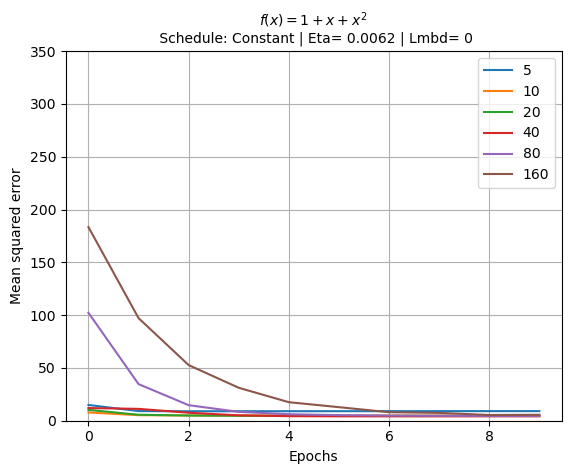

Adagrad: Eta=0.1624, Lambda=0.4833
  [=======================================>] 100.0% | train_error: 4.16 | val_error: 4.30 4.30130321784281
Adagrad: Eta=0.1624, Lambda=0.4833
  [=======================================>] 100.0% | train_error: 4.12 | val_error: 4.32 4.317490818904875
Adagrad: Eta=0.1624, Lambda=0.4833
  [=======================================>] 100.0% | train_error: 4.13 | val_error: 4.30 4.2958463994720475
Adagrad: Eta=0.1624, Lambda=0.4833
  [=======================================>] 100.0% | train_error: 4.19 | val_error: 4.56 4.556624463355678
Adagrad: Eta=0.1624, Lambda=0.4833
  [=======================================>] 100.0% | train_error: 4.29 | val_error: 4.88 4.878943823609074
Adagrad: Eta=0.1624, Lambda=0.4833
  [=======================================>] 100.0% | train_error: 7.98 | val_error: 9.58 9.57838452926921


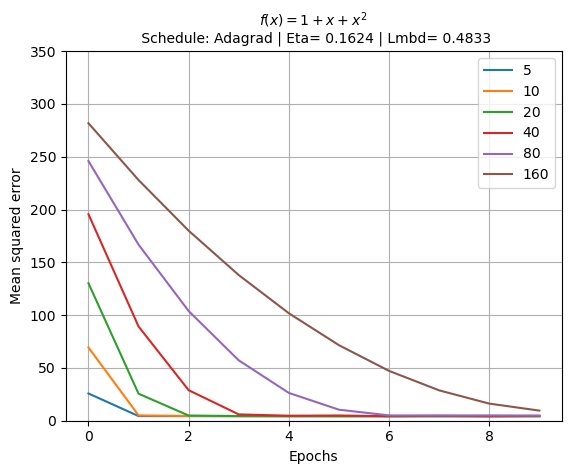

RMS_prop: Eta=0.0546, Lambda=0.0546
  [=======================================>] 100.0% | train_error: 4.32 | val_error: 4.23 4.234784633002657
RMS_prop: Eta=0.0546, Lambda=0.0546
  [=======================================>] 100.0% | train_error: 4.13 | val_error: 4.39 4.388170420681738
RMS_prop: Eta=0.0546, Lambda=0.0546
  [=======================================>] 100.0% | train_error: 4.08 | val_error: 4.26 4.259727726675718
RMS_prop: Eta=0.0546, Lambda=0.0546
  [=======================================>] 100.0% | train_error: 4.30 | val_error: 4.79 4.786640827725637
RMS_prop: Eta=0.0546, Lambda=0.0546
  [=======================================>] 100.0% | train_error: 4.56 | val_error: 5.15 5.1478480704149945
RMS_prop: Eta=0.0546, Lambda=0.0546
  [=======================================>] 100.0% | train_error: 5.01 | val_error: 5.99 5.991597024091274


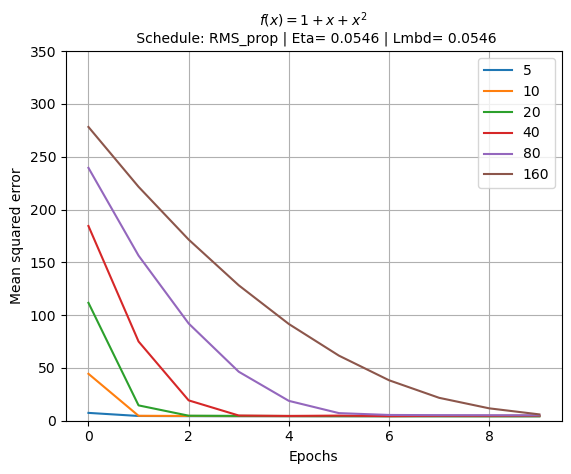

Adam: Eta=0.1624, Lambda=0.4833
  [=======================================>] 100.0% | train_error: 4.33 | val_error: 4.59 4.586915925262606
Adam: Eta=0.1624, Lambda=0.4833
  [=======================================>] 100.0% | train_error: 4.17 | val_error: 4.60 4.601891199401208
Adam: Eta=0.1624, Lambda=0.4833
  [=======================================>] 100.0% | train_error: 4.44 | val_error: 4.28 4.281943838899344
Adam: Eta=0.1624, Lambda=0.4833
  [=======================================>] 100.0% | train_error: 4.47 | val_error: 4.95 4.945689928146422
Adam: Eta=0.1624, Lambda=0.4833
  [=======================================>] 100.0% | train_error: 4.14 | val_error: 4.62 4.6176264828886
Adam: Eta=0.1624, Lambda=0.4833
  [=======================================>] 100.0% | train_error: 103 | val_error: 71.3 71.34242303946056


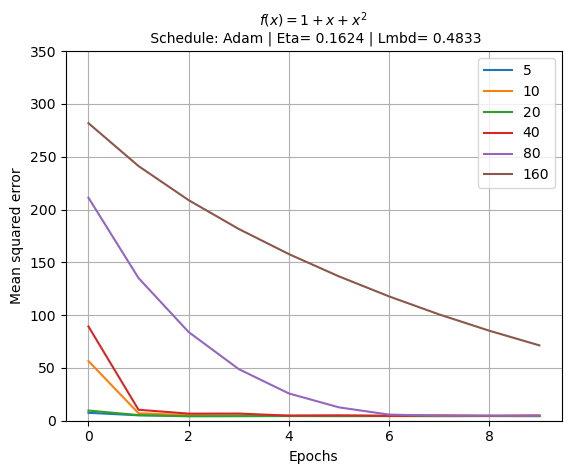

Momentum: Eta=0.0062, Lambda=0.1
  [=======================================>] 100.0% | train_error: 9.73 | val_error: 6.40 6.4039948832424445
Momentum: Eta=0.0062, Lambda=0.1
  [=======================================>] 100.0% | train_error: 4.55 | val_error: 4.20 4.19550035208487
Momentum: Eta=0.0062, Lambda=0.1
  [=======================================>] 100.0% | train_error: 4.16 | val_error: 4.21 4.207944559414137
Momentum: Eta=0.0062, Lambda=0.1
  [=======================================>] 100.0% | train_error: 4.27 | val_error: 4.16 4.163847227448511
Momentum: Eta=0.0062, Lambda=0.1
  [=======================================>] 100.0% | train_error: 4.19 | val_error: 4.35 4.351059833056389
Momentum: Eta=0.0062, Lambda=0.1
  [=======================================>] 100.0% | train_error: 4.50 | val_error: 4.42 4.415849680034163


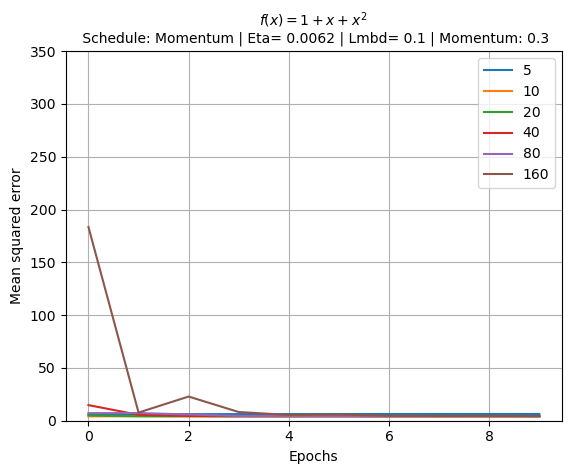

AdagradMomentum: Eta=0.0546, Lambda=0.4833
  [=======================================>] 100.0% | train_error: 4.11 | val_error: 4.38 4.381812700983487
AdagradMomentum: Eta=0.0546, Lambda=0.4833
  [=======================================>] 100.0% | train_error: 4.09 | val_error: 4.32 4.318481068871935
AdagradMomentum: Eta=0.0546, Lambda=0.4833
  [=======================================>] 100.0% | train_error: 4.05 | val_error: 4.34 4.336844743894871
AdagradMomentum: Eta=0.0546, Lambda=0.4833
  [=======================================>] 100.0% | train_error: 4.22 | val_error: 4.71 4.712271890715368
AdagradMomentum: Eta=0.0546, Lambda=0.4833
  [=======================================>] 100.0% | train_error: 39.8 | val_error: 31.0 30.966724977200666
AdagradMomentum: Eta=0.0546, Lambda=0.4833
  [=======================================>] 100.0% | train_error: 173 | val_error: 116 115.62862296629201


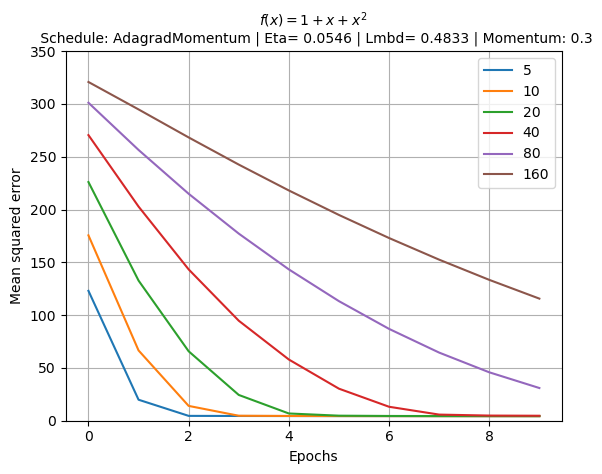

In [50]:
# check convergence with different batch sizes 

# Learning parameters
epochs = 10
batch_size = [5,10,20,40,80, 160]

# design matrix
X_test_reg = np.c_[np.ones((size_test,1)), x_test, x_test**2] 
X_train_reg = np.c_[np.ones((size_train,1)), x_train, x_train**2]

# would be safer to scale data, but gives unexpected results
# scaler = StandardScaler()
# X_train_reg = scaler.fit_transform(X_train_reg)
# X_test_reg = scaler.transform(X_test_reg) 

# Network architecture
input_nodes = X_train_reg.shape[1]
output_nodes = 1
dims=(input_nodes,output_nodes)

Scheduler =['Constant','Adagrad','RMS_prop','Adam','Momentum','AdagradMomentum']

for scheduler_name in Scheduler:
    # hardcoded values from the grid search above, should be fixed
    match scheduler_name:
        case 'Constant': 
            eta = 0.0062
            scheduler = Constant(eta=eta)
            lmbd=0
        case 'Adagrad':
            eta=0.1624
            scheduler = Adagrad(eta=eta)
            lmbd=0.4833
        case 'RMS_prop': 
            eta=0.0546
            scheduler = RMS_prop(eta=eta, rho=0.9)
            lmbd=0.0546
        case 'Adam':
            eta=0.1624
            scheduler = Adam(eta=eta, rho=0.9, rho2=0.999)
            lmbd=0.4833 
        case 'Momentum':
            eta=0.0062
            momentum = 0.3
            scheduler = Momentum(eta=eta, momentum = 0.3)
            lmbd=0.1
        case 'AdagradMomentum':
            eta=0.0546
            scheduler = AdagradMomentum(eta=eta, momentum = 0.3)
            lmbd=0.4833 
        
    fig1 = plt.figure()
    for b_size in batch_size:
        batches = x_train.shape[0]// b_size
        # ffnn without hidden layer, approximates linear regression
        linear_regression = FFNN(dims, output_func=identity,cost_func=CostOLS, seed=203)
        linear_regression.reset_weights() # reset weights such that previous runs or reruns don't affect the weights
        scores = linear_regression.fit(X_train_reg, 
                                       y_train,scheduler,
                                       epochs=epochs,
                                       lam=lmbd,
                                       batches=batches, 
                                       X_val=X_test_reg, 
                                       t_val=y_test)
        print(scores['val_errors'][-1])
        plt.plot(np.arange(epochs), scores['val_errors'], label = f'{b_size}' )

    if scheduler_name == 'Momentum':
        fig_title = ( '$f(x) = 1 + x + x^2$ \n Schedule: '+ 
                 scheduler_name +f' | Eta= {eta} | Lmbd= {lmbd} | Momentum: {momentum}' )
    elif scheduler_name == 'AdagradMomentum':
        fig_title = ( '$f(x) = 1 + x + x^2$ \n Schedule: '+ 
             scheduler_name +f' | Eta= {eta} | Lmbd= {lmbd} | Momentum: {momentum}' )
    else:
        fig_title = ( '$f(x) = 1 + x + x^2$ \n Schedule: '+ 
                 scheduler_name +f' | Eta= {eta} | Lmbd= {lmbd}' )
    plt.xlabel('Epochs')
    plt.ylabel('Mean squared error')
    plt.legend()
    plt.grid()
    plt.ylim((0, 350))
    plt.title(fig_title,fontsize=10)
    plt.show()
